In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from uszipcode import SearchEngine, SimpleZipcode
import plotly.graph_objects as go


/Users/rickypang/anaconda3/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
filepath = '/Users/rickypang/Desktop/Project-2-Linkedin-Analysis/data/job_postings.csv'
df=pd.read_csv(filepath)

#convert date columns to date time
df['listed_time'] = pd.to_datetime(df['listed_time'], unit='ms')
df['original_listed_time'] = pd.to_datetime(df['original_listed_time'], unit='ms')
df['expiry']=pd.to_datetime(df['expiry'],unit='ms')

#convert company ID to an int, convert NaN to NaN
df['company_id'] = pd.to_numeric(df['company_id'], errors='coerce').astype('Int64')

#Pre-process and convert NaNs in company ID to -1
df['company_id'] = df['company_id'].fillna(-1)

#display df
pd.set_option('display.max_columns',None)
df

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,applies,original_listed_time,remote_allowed,views,job_posting_url,application_url,application_type,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,scraped
0,3757940104,553718,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.00,NaN,MONTHLY,Full-time,"Little River, SC",NaN,2023-11-04 09:26:40,NaN,9.0,https://www.linkedin.com/jobs/view/3757940104/...,https://careers-demant.icims.com/jobs/19601/he...,OffsiteApply,2023-12-04 08:53:20,NaN,Entry level,NaN,2023-11-04 09:26:40,careers-demant.icims.com,0,FULL_TIME,USD,BASE_SALARY,1699138101
1,3757940025,2192142,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",NaN,2023-11-04 06:40:00,NaN,NaN,https://www.linkedin.com/jobs/view/3757940025/...,https://www.click2apply.net/mXLQz5S5NEYEXsKjwH...,OffsiteApply,2023-12-04 08:53:20,NaN,NaN,NaN,2023-11-04 06:40:00,www.click2apply.net,0,FULL_TIME,NaN,NaN,1699085420
2,3757938019,474443,"Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...,NaN,NaN,NaN,NaN,Full-time,"Bessemer, AL",NaN,2023-11-04 06:40:00,NaN,NaN,https://www.linkedin.com/jobs/view/3757938019/...,https://www.click2apply.net/LwbOykH2yAJdahB5Ah...,OffsiteApply,2023-12-04 08:53:20,NaN,NaN,Bachelor's Degree in Mechanical Engineering pr...,2023-11-04 06:40:00,www.click2apply.net,0,FULL_TIME,NaN,NaN,1699085644
3,3757938018,18213359,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,22.27,NaN,HOURLY,Full-time,"Aliso Viejo, CA",NaN,2023-11-04 06:40:00,NaN,1.0,https://www.linkedin.com/jobs/view/3757938018/...,https://jobs.apploi.com/view/854782?utm_campai...,OffsiteApply,2023-12-04 08:53:20,NaN,Entry level,NaN,2023-11-04 06:40:00,jobs.apploi.com,0,FULL_TIME,USD,BASE_SALARY,1699087461
4,3757937095,437225,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,NaN,205956.0,YEARLY,Full-time,United States,NaN,2023-11-03 00:06:40,1.0,NaN,https://www.linkedin.com/jobs/view/3757937095/...,https://careers.iherb.com/global/en/job/IHINGL...,OffsiteApply,2023-12-04 08:53:20,NaN,Mid-Senior level,NaN,2023-11-04 09:26:40,careers.iherb.com,0,FULL_TIME,USD,BASE_SALARY,1699085346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33241,133114754,77766802,Sales Manager,Are you a dynamic and creative marketing profe...,NaN,NaN,NaN,NaN,Full-time,"Santa Clarita, CA",NaN,2023-08-23 22:33:20,NaN,NaN,https://www.linkedin.com/jobs/view/133114754/?...,NaN,ComplexOnsiteApply,2023-09-23 00:46:40,NaN,NaN,NaN,2023-08-23 22:33:20,NaN,0,FULL_TIME,NaN,NaN,1
33242,108965123,-1,Office Administrative Assistant,"A fast-fashion wholesaler, is looking for a fu...",NaN,NaN,NaN,NaN,Full-time,"New York, NY",2.0,2023-11-03 19:33:20,NaN,4.0,https://www.linkedin.com/jobs/view/108965123/?...,NaN,ComplexOnsiteApply,2023-12-03 19:00:00,NaN,NaN,NaN,2023-11-03 19:33:20,NaN,0,FULL_TIME,NaN,NaN,1699044401
33243,102339515,52132271,Franchise Owner,DuctVentz is a dryer and A/C – heat vent clean...,NaN,NaN,NaN,NaN,Full-time,Greater Boston,NaN,2023-11-03 22:20:00,NaN,NaN,https://www.linkedin.com/jobs/view/102339515/?...,NaN,SimpleOnsiteApply,2023-12-03 21:46:40,NaN,NaN,NaN,2023-11-03 22:20:00,NaN,0,FULL_TIME,NaN,NaN,1699063495
33244,85008768,-1,Licensed Insurance Agent,While many industries were hurt by the last fe...,52000.0,NaN,45760.0,YEARLY,Full-time,"Chico, CA",NaN,2023-08-23 00:20:00,NaN,5.0,https://www.linkedin.com/jobs/view/85008768/?t...,NaN,ComplexOnsiteApply,2024-02-18 23:46:40,NaN,NaN,NaN,2023-08-23 00:20:00,NaN,1,FULL_TIME,USD,BASE_SALARY,1


In [3]:
df.isnull().sum()
#drop columns..
#closed time
#application url
#posting domain
#skills_desc (but add other dataset)
#clean industry column in the other dataset
#drop original listed time
df = df.drop(['closed_time', 'application_url', 'posting_domain', 'skills_desc', 'original_listed_time',], axis=1)




In [4]:

#other clean up
#location - some remote jobs list location as United States
#some list countries instead of cities
#look over remote allowed column - does null mean that remote is not allowed?
#go through job posting workflow 
#some cities are listed as san francisco bay area - this should include san mateo / sunnyvale?
#some jobs are listed in multiple cities for one actual job - how to deal with this?
#we dont know how accurate the views are because the views are a snapshot taken when the scrape was done (we dont know when the listing time was)
#job title standardization 

# Extracting city, state, and country
df[['City', 'State', 'Country']] = df['location'].str.extract(r'([^,]+)?,?\s?([^,]+)?,?\s?([^\d]+)?')

# Filling missing values in 'Country' with 'United States' if the state is present
df['Country'].fillna('United States', inplace=True)
df[['City', 'State', 'Country']]


,City,State,Country
0,Little River,SC,United States
1,Beaver Dam,WI,United States
2,Bessemer,AL,United States
3,Aliso Viejo,CA,United States
4,United States,NaN,United States
...,...,...,...
33241,Santa Clarita,CA,United States
33242,New York,NY,United States
33243,Greater Boston,NaN,United States
33244,Chico,CA,United States


In [5]:
df_sorted = df.sort_values(by='max_salary', ascending=False)
df_sorted

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,applies,remote_allowed,views,job_posting_url,application_type,expiry,formatted_experience_level,listed_time,sponsored,work_type,currency,compensation_type,scraped,City,State,Country
27035,3694103424,92699700,Quantitative Developer,Goliath Partners has a requirement at a leadin...,1300000.0,NaN,800000.0,YEARLY,Full-time,Greater Chicago Area,14.0,NaN,49.0,https://www.linkedin.com/jobs/view/3694103424/...,ComplexOnsiteApply,2023-09-23 00:46:40,Mid-Senior level,2023-08-24 01:20:00,0,FULL_TIME,USD,BASE_SALARY,1,Greater Chicago Area,NaN,United States
17561,3701369748,106584,Fintech Startup | Tech Lead Manager - Software...,Tech Lead / Manager | Software EngineerSelby J...,1100000.0,NaN,500000.0,YEARLY,Full-time,United States,NaN,1.0,368.0,https://www.linkedin.com/jobs/view/3701369748/...,ComplexOnsiteApply,2023-09-21 21:00:00,Mid-Senior level,2023-08-22 21:33:20,0,FULL_TIME,USD,BASE_SALARY,1,United States,NaN,United States
18120,3701326157,106584,Tech Lead Manager (L6-L8) | Disruptive FinTech,Tech Lead Manager (L6-L8) | Disruptive FinTech...,1000000.0,NaN,750000.0,YEARLY,Full-time,"Palo Alto, CA",48.0,1.0,166.0,https://www.linkedin.com/jobs/view/3701326157/...,ComplexOnsiteApply,2023-12-20 19:20:00,Mid-Senior level,2023-08-23 22:33:20,1,FULL_TIME,USD,BASE_SALARY,1,Palo Alto,CA,United States
12010,3755585686,3560734,Life Science Consulting Partner,We set out to develop a health care innovation...,900000.0,NaN,400000.0,YEARLY,Full-time,"New York, NY",19.0,1.0,116.0,https://www.linkedin.com/jobs/view/3755585686/...,ComplexOnsiteApply,2023-12-03 21:46:40,Mid-Senior level,2023-11-03 19:33:20,0,FULL_TIME,USD,BASE_SALARY,1699059350,New York,NY,United States
30821,3693052192,-1,Urologist,Here are the Details: Location: DC/Baltimore ...,800000.0,NaN,600000.0,YEARLY,Full-time,"Baltimore, MD",NaN,NaN,6.0,https://www.linkedin.com/jobs/view/3693052192/...,ComplexOnsiteApply,2023-09-21 21:00:00,NaN,2023-08-22 21:33:20,0,FULL_TIME,USD,BASE_SALARY,1,Baltimore,MD,United States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33239,218881389,-1,Accounting Associate,My client a local office is seeking an Account...,NaN,NaN,NaN,NaN,Full-time,"Bolingbrook, IL",1.0,NaN,2.0,https://www.linkedin.com/jobs/view/218881389/?...,ComplexOnsiteApply,2023-12-03 21:46:40,NaN,2023-11-03 22:20:00,0,FULL_TIME,NaN,NaN,1699084455,Bolingbrook,IL,United States
33240,133196985,1089558,Model Risk Auditor,Join Us as a Model Risk Auditor – Showcase You...,NaN,NaN,NaN,NaN,Contract,"New York, NY",1.0,NaN,17.0,https://www.linkedin.com/jobs/view/133196985/?...,ComplexOnsiteApply,2023-09-21 18:13:20,NaN,2023-08-22 18:46:40,0,CONTRACT,NaN,NaN,1,New York,NY,United States
33241,133114754,77766802,Sales Manager,Are you a dynamic and creative marketing profe...,NaN,NaN,NaN,NaN,Full-time,"Santa Clarita, CA",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/133114754/?...,ComplexOnsiteApply,2023-09-23 00:46:40,NaN,2023-08-23 22:33:20,0,FULL_TIME,NaN,NaN,1,Santa Clarita,CA,United States
33242,108965123,-1,Office Administrative Assistant,"A fast-fashion wholesaler, is looking for a fu...",NaN,NaN,NaN,NaN,Full-time,"New York, NY",2.0,NaN,4.0,https://www.linkedin.com/jobs/view/108965123/?...,ComplexOnsiteApply,2023-12-03 19:00:00,NaN,2023-11-03 19:33:20,0,FULL_TIME,NaN,NaN,1699044401,New York,NY,United States


In [6]:
# Identify duplicates based on 'company_id' and 'title'
duplicates_mask = df.duplicated(subset=['company_id', 'title'], keep=False)

# Filter the DataFrame to show only the duplicate rows
duplicate_rows = df[duplicates_mask]

# Display the duplicate rows - these rows signify listings that are the same title and same company - we have opted to leave these in the dataset
duplicate_rows

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,applies,remote_allowed,views,job_posting_url,application_type,expiry,formatted_experience_level,listed_time,sponsored,work_type,currency,compensation_type,scraped,City,State,Country
3,3757938018,18213359,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,22.27,NaN,HOURLY,Full-time,"Aliso Viejo, CA",NaN,NaN,1.0,https://www.linkedin.com/jobs/view/3757938018/...,OffsiteApply,2023-12-04 08:53:20,Entry level,2023-11-04 06:40:00,0,FULL_TIME,USD,BASE_SALARY,1699087461,Aliso Viejo,CA,United States
4,3757937095,437225,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,NaN,205956.0,YEARLY,Full-time,United States,NaN,1.0,NaN,https://www.linkedin.com/jobs/view/3757937095/...,OffsiteApply,2023-12-04 08:53:20,Mid-Senior level,2023-11-04 09:26:40,0,FULL_TIME,USD,BASE_SALARY,1699085346,United States,NaN,United States
8,3757936097,18213359,Dishwasher,"descriptionTitle\n\n $2,000 Sign-on Bonus Guar...",NaN,19.30,NaN,HOURLY,Full-time,"Aliso Viejo, CA",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/3757936097/...,OffsiteApply,2023-12-04 08:53:20,Entry level,2023-11-04 06:40:00,0,FULL_TIME,USD,BASE_SALARY,1699089324,Aliso Viejo,CA,United States
14,3757935025,99500291,Associate Veterinarian,We are looking to hire an Associate Veterinari...,NaN,NaN,NaN,NaN,Full-time,"St Clair Shores, Michigan, United States",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/3757935025/...,OffsiteApply,2023-12-04 06:06:40,Mid-Senior level,2023-11-04 06:40:00,0,FULL_TIME,NaN,NaN,1699131931,St Clair Shores,Michigan,United States
16,3757935011,82556159,Remote Vacation Planner,Full Job Description\n\nWe are focused on prov...,NaN,NaN,NaN,NaN,Full-time,"Raleigh, NC",NaN,1.0,NaN,https://www.linkedin.com/jobs/view/3757935011/...,OffsiteApply,2023-12-04 06:06:40,Entry level,2023-11-04 06:40:00,0,FULL_TIME,NaN,NaN,1699084233,Raleigh,NC,United States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33219,2148434019,1016,"Virtual Sales Associate Account Manager, Women...",Job Description Summary \n\nAs the Virtual Sal...,NaN,NaN,NaN,NaN,Full-time,"Connecticut, United States",NaN,1.0,NaN,https://www.linkedin.com/jobs/view/2148434019/...,OffsiteApply,2023-09-23 03:33:20,Entry level,2023-08-24 04:06:40,0,FULL_TIME,NaN,NaN,1,Connecticut,United States,United States
33220,2148434014,1016,"Virtual Sales Associate Account Manager, Women...",Job Description Summary \n\nAs the Virtual Sal...,NaN,NaN,NaN,NaN,Full-time,"Maine, United States",NaN,1.0,NaN,https://www.linkedin.com/jobs/view/2148434014/...,OffsiteApply,2023-09-23 03:33:20,Entry level,2023-08-24 04:06:40,0,FULL_TIME,NaN,NaN,1,Maine,United States,United States
33227,1535492735,-1,Administrative Assistant,We are looking for a responsible Administrativ...,20.0,NaN,18.0,HOURLY,Part-time,"Ocoee, FL",3.0,NaN,5.0,https://www.linkedin.com/jobs/view/1535492735/...,ComplexOnsiteApply,2024-02-18 21:00:00,NaN,2023-08-22 21:33:20,0,PART_TIME,USD,BASE_SALARY,1,Ocoee,FL,United States
33229,1483357774,-1,Video Editor,POSITION: Lead EditorREPORTS TO: Founder and D...,NaN,NaN,NaN,NaN,Full-time,"Louisville, KY",7.0,NaN,40.0,https://www.linkedin.com/jobs/view/1483357774/...,ComplexOnsiteApply,2023-09-21 18:13:20,NaN,2023-08-22 18:46:40,0,FULL_TIME,NaN,NaN,1,Louisville,KY,United States


/var/folders/5n/f53vsb0n34q3sstd084mv7g80000gn/T/ipykernel_33013/3928678452.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  c=df.corr()
/var/folders/5n/f53vsb0n34q3sstd084mv7g80000gn/T/ipykernel_33013/3928678452.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask=np.ones_like(c, dtype=np.bool)


<Axes: >

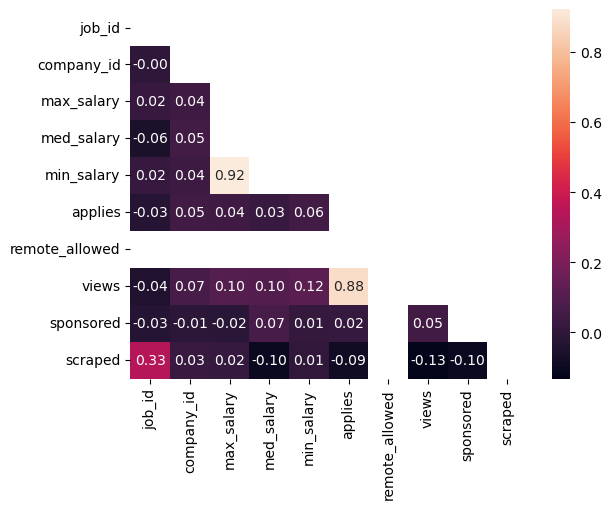

In [7]:
c=df.corr()
mask=np.ones_like(c, dtype=np.bool)
mask=np.triu(mask)
sns.heatmap(c, annot=True, fmt=".2f", annot_kws={"size": 10},mask=mask)

In [19]:
filepathforcompany = '/Users/rickypang/Desktop/Project-2-Linkedin-Analysis/data/company_details/companies.csv'
filepathforjob = '~/Downloads/data-for-project-2/job_details/job_industries.csv'
filepathforindustry = '~/Downloads/data-for-project-2/maps/industries.csv'

df2 = pd.read_csv(filepathforcompany)

df3=pd.read_csv(filepathforjob)
df4=pd.read_csv(filepathforindustry)


,job_id,industry_id
0,3378133231,68
1,3497509795,96
2,3690843087,47
3,3691775263,112
4,3691779379,80
...,...,...
44086,3757486249,47
44087,3757486249,43
44088,3757780487,104
44089,3757934256,80


In [21]:
df3 = df3.drop_duplicates(subset='job_id', keep='first')
df3.nunique()

job_id         33090
industry_id      222
dtype: int64

In [22]:
#left join df with company info on company_id
result_df = pd.merge(df, df2, on='company_id', how='left')
result_df=pd.merge(result_df,df3, on='job_id',how='left')
result_df=pd.merge(result_df,df4, on='industry_id',how='left')

#replace the -1s with NaN in company_id
result_df['company_id'] = result_df['company_id'].replace(-1, np.nan)

#show the new df - remote allowed and missing location
filtered_rows = result_df[(result_df['remote_allowed'] == 1.0) & result_df['zip_code'].isna()]
filtered_rows


,job_id,company_id,title,description_x,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,applies,remote_allowed,views,job_posting_url,application_type,expiry,formatted_experience_level,listed_time,sponsored,work_type,currency,compensation_type,scraped,City,State,Country,name,description_y,company_size,state,country,city,zip_code,address,url,industry_id,industry_name
566,3757908631,<NA>,Structural/Miscellaneous Detailer,Company DescriptionWe suggest you enter detail...,NaN,NaN,NaN,NaN,Full-time,United States,6.0,1.0,12.0,https://www.linkedin.com/jobs/view/3757908631/...,ComplexOnsiteApply,2023-12-04 06:06:40,NaN,2023-11-04 03:53:20,0,FULL_TIME,NaN,NaN,1699083269,United States,NaN,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1198,3757752019,<NA>,Customer Service Representative,Star City Staffing was founded in 2020 with a ...,NaN,NaN,NaN,NaN,Full-time,United States,20.0,1.0,58.0,https://www.linkedin.com/jobs/view/3757752019/...,ComplexOnsiteApply,2023-12-04 00:33:20,NaN,2023-11-04 01:06:40,0,FULL_TIME,NaN,NaN,1699082602,United States,NaN,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1235,3757751157,<NA>,Real Estate Agent,Help Wanted: Real Estate Agents\n\nAre you a m...,NaN,NaN,NaN,NaN,Contract,United States,3.0,1.0,43.0,https://www.linkedin.com/jobs/view/3757751157/...,SimpleOnsiteApply,2023-12-04 00:33:20,NaN,2023-11-04 01:06:40,0,CONTRACT,NaN,NaN,1699135161,United States,NaN,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1301,3757749881,<NA>,UI/UX Designer,We are seeking a talented UI/UX Designer to jo...,NaN,NaN,NaN,NaN,Full-time,"Louisiana, United States",162.0,1.0,298.0,https://www.linkedin.com/jobs/view/3757749881/...,ComplexOnsiteApply,2024-05-02 00:33:20,NaN,2023-11-04 01:06:40,0,FULL_TIME,NaN,NaN,1699080458,Louisiana,United States,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1354,3757748411,<NA>,Personal Assistant to Chief Executive Officer,Position Overview:\nAs a remote personal assis...,NaN,NaN,NaN,NaN,Full-time,United States,209.0,1.0,519.0,https://www.linkedin.com/jobs/view/3757748411/...,ComplexOnsiteApply,2024-05-02 00:33:20,NaN,2023-11-04 01:06:40,1,FULL_TIME,NaN,NaN,1699080680,United States,NaN,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32936,3691797973,145145,Sales Specialist,Looking for a Business development specialist ...,NaN,NaN,NaN,NaN,Full-time,United States,NaN,1.0,9.0,https://www.linkedin.com/jobs/view/3691797973/...,ComplexOnsiteApply,2023-09-20 20:00:00,Executive,2023-08-21 17:46:40,0,FULL_TIME,NaN,NaN,1,United States,NaN,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,Pharmaceutical Manufacturing
32941,3691795980,7573454,Data Engineer,"Job Description:\n• Design, develop, and launc...",NaN,NaN,NaN,NaN,Contract,United States,55.0,1.0,101.0,https://www.linkedin.com/jobs/view/3691795980/...,ComplexOnsiteApply,2023-09-20 20:00:00,NaN,2023-08-21 17:46:40,0,CONTRACT,NaN,NaN,1,United States,NaN,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.0,IT Services and IT Consulting
33021,3690697852,<NA>,Manufacturers' Outside Sales Representative,DH Sales Company is a growing Manufacturers’ R...,NaN,NaN,NaN,NaN,Full-time,"Charlotte, NC",90.0,1.0,430.0,https://www.linkedin.com/jobs/view/3690697852/...,ComplexOnsiteApply,2024-02-06 17:20:00,NaN,2023-08-10 17:53:20,1,FULL_TIME,NaN,NaN,1,Charlotte,NC,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33124,3644195109,<NA>,Call Center Representative,This is a 1099 position. Pay is based off of t...,NaN,NaN,NaN,NaN,Full-time,Atlanta Metropolitan Area,1.0,1.0,2.0,https://www.linkedin.com/jobs/view/3644195109/...,ComplexOnsiteApply,2023-09-22 22:00:00,NaN,2023-08-23 22:33:20,0,FULL_TIME,NaN,NaN,1,Atlanta Metropolitan Area,NaN,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
len(result_df)

33246

In [24]:
result_df['currency'].unique()

array(['USD', nan], dtype=object)

In [25]:
# Create a function to fetch city, state, median home value, and median household income information
def get_zipcode_info(zipcode):
    search = SearchEngine()
    result = search.by_zipcode(zipcode)
    
    if result:
        return result.major_city, result.state, result.median_home_value, result.median_household_income, result.state_abbr
    else:
        return None, None, None, None, None

# Apply the function to create new columns
result_df[['major_city', 'state', 'median_home_value', 'median_household_income', 'state_abbr']] = result_df['zip_code'].apply(lambda x: pd.Series(get_zipcode_info(x)))

In [27]:
result_df['state_match'] = result_df['state'] == result_df['state_abbr']

# Filter the DataFrame to show only rows where there is a mismatch
mismatch_df = result_df[result_df['state_match'] == False]

# Display the DataFrame with mismatches
len(mismatch_df)

6265

In [28]:
len(result_df)

33246

## Below this cell is used for hypothesis 2 data wrangling ##

In [29]:
#this cell will be used for hypothesis 2
#skill level

filepathforskill = '~/Downloads/data-for-project-2/job_details/job_skills.csv'
filepathforskillfull='~/Downloads/data-for-project-2/maps/skills.csv'

df5=pd.read_csv(filepathforskill)

df6=pd.read_csv(filepathforskillfull)

result_df=result_df.merge(df5,on='job_id',how='left')

result_df

,job_id,company_id,title,description_x,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,applies,remote_allowed,views,job_posting_url,application_type,expiry,formatted_experience_level,listed_time,sponsored,work_type,currency,compensation_type,scraped,City,State,Country,name,description_y,company_size,state,country,city,zip_code,address,url,industry_id,industry_name,major_city,median_home_value,median_household_income,state_abbr,state_match,skill_abr
0,3757940104,553718,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.00,NaN,MONTHLY,Full-time,"Little River, SC",NaN,NaN,9.0,https://www.linkedin.com/jobs/view/3757940104/...,OffsiteApply,2023-12-04 08:53:20,Entry level,2023-11-04 09:26:40,0,FULL_TIME,USD,BASE_SALARY,1699138101,Little River,SC,United States,HearingLife,HearingLife is a national hearing care company...,5.0,NJ,US,Somerset,08873,580 Howard Avenue,https://www.linkedin.com/company/hearing-life,17.0,Medical Equipment Manufacturing,Somerset,332400.0,85148.0,NJ,True,OTHR
1,3757940025,2192142,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/3757940025/...,OffsiteApply,2023-12-04 08:53:20,NaN,2023-11-04 06:40:00,0,FULL_TIME,NaN,NaN,1699085420,Beaver Dam,WI,United States,"Metalcraft of Mayville, Inc.","Headquartered in Mayville, Wisconsin, Metalcra...",4.0,WI,US,Mayville,53050,1000 Metalcraft Drive,https://www.linkedin.com/company/metalcraft-of...,135.0,Industrial Machinery Manufacturing,Mayville,149500.0,57292.0,WI,True,MGMT
2,3757940025,2192142,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/3757940025/...,OffsiteApply,2023-12-04 08:53:20,NaN,2023-11-04 06:40:00,0,FULL_TIME,NaN,NaN,1699085420,Beaver Dam,WI,United States,"Metalcraft of Mayville, Inc.","Headquartered in Mayville, Wisconsin, Metalcra...",4.0,WI,US,Mayville,53050,1000 Metalcraft Drive,https://www.linkedin.com/company/metalcraft-of...,135.0,Industrial Machinery Manufacturing,Mayville,149500.0,57292.0,WI,True,MNFC
3,3757938019,474443,"Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...,NaN,NaN,NaN,NaN,Full-time,"Bessemer, AL",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/3757938019/...,OffsiteApply,2023-12-04 08:53:20,NaN,2023-11-04 06:40:00,0,FULL_TIME,NaN,NaN,1699085644,Bessemer,AL,United States,"U.S. Tsubaki Power Transmission, LLC","U.S. Tsubaki Power Transmission, LLC is a subs...",4.0,IL,US,Wheeling,60090,301E Marquardt Drive,https://www.linkedin.com/company/u.s.-tsubaki-...,147.0,Automation Machinery Manufacturing,Wheeling,193200.0,58466.0,IL,True,ENG
4,3757938018,18213359,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,22.27,NaN,HOURLY,Full-time,"Aliso Viejo, CA",NaN,NaN,1.0,https://www.linkedin.com/jobs/view/3757938018/...,OffsiteApply,2023-12-04 08:53:20,Entry level,2023-11-04 06:40:00,0,FULL_TIME,USD,BASE_SALARY,1699087461,Aliso Viejo,CA,United States,Episcopal Communities & Services,Episcopal Communities & Services (ECS) has bec...,4.0,CA,US,Altadena,91001,2212 El Molino Ave,https://www.linkedin.com/company/episcopal-com...,100.0,Non-profit Organizations,Altadena,550000.0,85108.0,CA,True,MGMT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56866,85008768,<NA>,Licensed Insurance Agent,While many industries were hurt by the last fe...,52000.0,NaN,45760.0,YEARLY,Full-time,"Chico, CA",NaN,NaN,5.0,https://www.linkedin.com/jobs/view/85008768/?t...,ComplexOnsiteApply,2024-02-18 23:46:40,NaN,2023-08-23 00:20:00,1,FULL_TIME,USD,BASE_SALARY,1,Chico,CA,United States,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,42.0,Insurance,None,NaN,NaN,None,False,SALE
56867,85008768,<NA>,License

In [30]:
#left join skills to main table
result_df=pd.merge(result_df,df6,on='skill_abr',how='left')
result_df

,job_id,company_id,title,description_x,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,applies,remote_allowed,views,job_posting_url,application_type,expiry,formatted_experience_level,listed_time,sponsored,work_type,currency,compensation_type,scraped,City,State,Country,name,description_y,company_size,state,country,city,zip_code,address,url,industry_id,industry_name,major_city,median_home_value,median_household_income,state_abbr,state_match,skill_abr,skill_name
0,3757940104,553718,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.00,NaN,MONTHLY,Full-time,"Little River, SC",NaN,NaN,9.0,https://www.linkedin.com/jobs/view/3757940104/...,OffsiteApply,2023-12-04 08:53:20,Entry level,2023-11-04 09:26:40,0,FULL_TIME,USD,BASE_SALARY,1699138101,Little River,SC,United States,HearingLife,HearingLife is a national hearing care company...,5.0,NJ,US,Somerset,08873,580 Howard Avenue,https://www.linkedin.com/company/hearing-life,17.0,Medical Equipment Manufacturing,Somerset,332400.0,85148.0,NJ,True,OTHR,Other
1,3757940025,2192142,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/3757940025/...,OffsiteApply,2023-12-04 08:53:20,NaN,2023-11-04 06:40:00,0,FULL_TIME,NaN,NaN,1699085420,Beaver Dam,WI,United States,"Metalcraft of Mayville, Inc.","Headquartered in Mayville, Wisconsin, Metalcra...",4.0,WI,US,Mayville,53050,1000 Metalcraft Drive,https://www.linkedin.com/company/metalcraft-of...,135.0,Industrial Machinery Manufacturing,Mayville,149500.0,57292.0,WI,True,MGMT,Management
2,3757940025,2192142,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/3757940025/...,OffsiteApply,2023-12-04 08:53:20,NaN,2023-11-04 06:40:00,0,FULL_TIME,NaN,NaN,1699085420,Beaver Dam,WI,United States,"Metalcraft of Mayville, Inc.","Headquartered in Mayville, Wisconsin, Metalcra...",4.0,WI,US,Mayville,53050,1000 Metalcraft Drive,https://www.linkedin.com/company/metalcraft-of...,135.0,Industrial Machinery Manufacturing,Mayville,149500.0,57292.0,WI,True,MNFC,Manufacturing
3,3757938019,474443,"Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...,NaN,NaN,NaN,NaN,Full-time,"Bessemer, AL",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/3757938019/...,OffsiteApply,2023-12-04 08:53:20,NaN,2023-11-04 06:40:00,0,FULL_TIME,NaN,NaN,1699085644,Bessemer,AL,United States,"U.S. Tsubaki Power Transmission, LLC","U.S. Tsubaki Power Transmission, LLC is a subs...",4.0,IL,US,Wheeling,60090,301E Marquardt Drive,https://www.linkedin.com/company/u.s.-tsubaki-...,147.0,Automation Machinery Manufacturing,Wheeling,193200.0,58466.0,IL,True,ENG,Engineering
4,3757938018,18213359,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,22.27,NaN,HOURLY,Full-time,"Aliso Viejo, CA",NaN,NaN,1.0,https://www.linkedin.com/jobs/view/3757938018/...,OffsiteApply,2023-12-04 08:53:20,Entry level,2023-11-04 06:40:00,0,FULL_TIME,USD,BASE_SALARY,1699087461,Aliso Viejo,CA,United States,Episcopal Communities & Services,Episcopal Communities & Services (ECS) has bec...,4.0,CA,US,Altadena,91001,2212 El Molino Ave,https://www.linkedin.com/company/episcopal-com...,100.0,Non-profit Organizations,Altadena,550000.0,85108.0,CA,True,MGMT,Management
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56866,85008768,<NA>,Licensed Insurance Agent,While many industries were hurt by the last fe...,52000.0,NaN,45760.0,YEARLY,Full-time,"Chico, CA",NaN,NaN,5.0,https://www.linkedin.com/jobs/view/85008768/?t...,ComplexOnsiteApply,2024-02-18 23:46:40,NaN,2023-08-23 00:20:00,1,FULL_TIME,USD,BASE_SALARY,1,Chico,CA,United States,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,42

## The cells below are for skill level and skill name analysis ##

In [31]:
result_df.columns
# Group by 'skill_name' and count the occurrences
skill_counts = result_df['skill_name'].value_counts().reset_index()

# Rename the columns for clarity
skill_counts.columns = ['skill_name', 'count']

skill_counts

,skill_name,count
0,Information Technology,7307
1,Sales,5480
2,Management,5082
3,Manufacturing,4585
4,Health Care Provider,3820
5,Engineering,3764
6,Business Development,3588
7,Other,3026
8,Finance,2468
9,Accounting/Auditing,1636


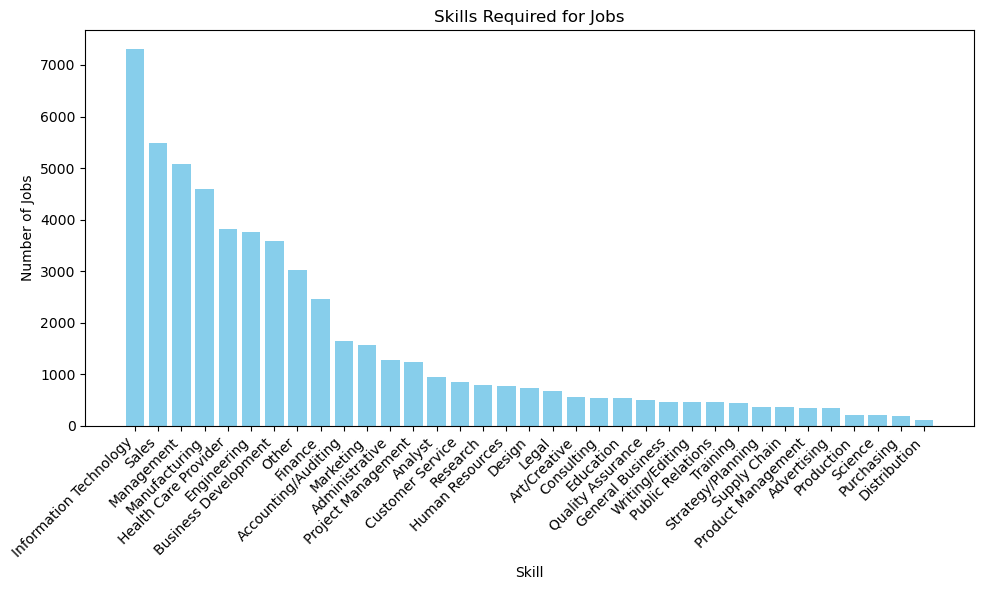

In [32]:
# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(skill_counts['skill_name'], skill_counts['count'], color='skyblue')
plt.xlabel('Skill')
plt.ylabel('Number of Jobs')
plt.title('Skills Required for Jobs')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [33]:
skills_by_level=result_df.groupby(['skill_name','formatted_experience_level']).size().reset_index(name='count')
skills_by_level

,skill_name,formatted_experience_level,count
0,Accounting/Auditing,Associate,270
1,Accounting/Auditing,Director,89
2,Accounting/Auditing,Entry level,240
3,Accounting/Auditing,Executive,22
4,Accounting/Auditing,Internship,30
...,...,...,...
201,Writing/Editing,Director,20
202,Writing/Editing,Entry level,86
203,Writing/Editing,Executive,4
204,Writing/Editing,Internship,5


In [34]:
skills_by_level['formatted_experience_level'].unique()

array(['Associate', 'Director', 'Entry level', 'Executive', 'Internship',
       'Mid-Senior level'], dtype=object)

<Figure size 3000x1500 with 0 Axes>

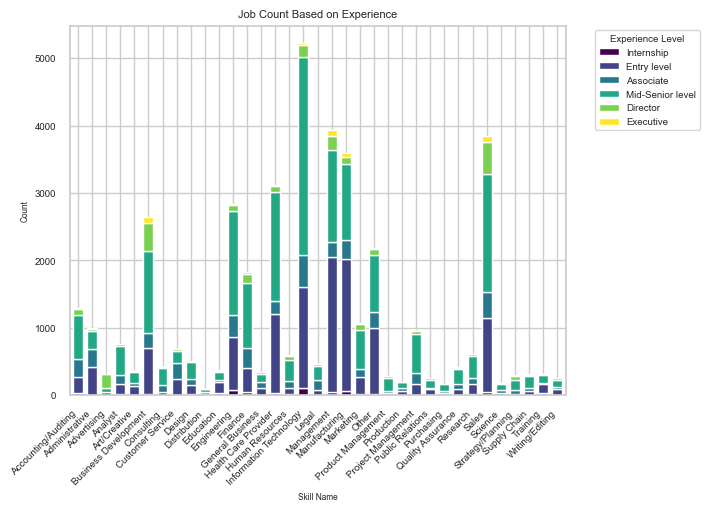

In [35]:
pivot_df = skills_by_level.pivot(index='skill_name', columns='formatted_experience_level', values='count')

# Reorder columns to match the specified order
desired_order = ['Internship','Entry level','Associate','Mid-Senior level','Director', 'Executive']
pivot_df = pivot_df[desired_order]

# Increase the width of the plot area
plt.figure(figsize=(30, 15))  # Adjust the width as needed
sns.set(style="whitegrid")  # Optional, but it enhances the appearance of the plot
ax = pivot_df.plot(kind='bar', stacked=True, colormap='viridis', width=0.7)
plt.xlabel('Skill Name', fontsize=6)
plt.ylabel('Count', fontsize=6)
plt.title('Job Count Based on Experience',fontsize=8)
plt.legend(title='Experience Level', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7, title_fontsize=7) 
plt.xticks(rotation=45, ha='right',fontsize=7.1)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=7)
plt.show()

## Hypothesis 2 end here ##

In [ ]:
average_salary_by_state = result_df.groupby('state_abbr')['med_salary'].mean().reset_index()
average_salary_by_state

In [ ]:
fig = go.Figure(data=go.Choropleth(
    locations=average_salary_by_state['state_abbr'],
    z=average_salary_by_state['med_salary'],
    locationmode='USA-states',
    colorscale='Viridis',  # You can choose a different colorscale
    zmin=average_salary_by_state['med_salary'].min(),  # Set the minimum value of the color scale
    zmax=average_salary_by_state['med_salary'].max(),  # Set the maximum value of the color scale
    colorbar=dict(
        title='Median Salary',
        tickprefix='$',  # Add a dollar sign as a prefix to colorbar ticks
        ticks='outside',  # Place colorbar ticks outside the colorbar
        ticklen=5,  # Set the length of the tick marks
        tickmode='array',  # Set the tick mode to 'array' for custom ticks
        tickvals=[10000, 50000, 100000,150000],  # Customize the colorbar tick values
    )
))

fig.update_layout(
    title_text='LinkedIn Salaries by State',
    geo=dict(
        showlakes=True,
        projection=go.layout.geo.Projection(type='albers usa'),
        scope='usa'
    )
)

fig.show()

In [ ]:
result_df['month_year'] = result_df['expiry'].dt.to_period('D')
monthly_counts = result_df['month_year'].value_counts().sort_index()
monthly_counts_df = pd.DataFrame({'month_year': monthly_counts.index, 'count': monthly_counts.values})
monthly_counts_df = monthly_counts_df.sort_values(by='month_year')
plt.figure(figsize=(10, 6))
plt.plot(monthly_counts_df['month_year'].dt.to_timestamp(), monthly_counts_df['count'], marker='o', linestyle='-')
plt.title('Job Postings per Month')
plt.xlabel('Month and Year')
plt.ylabel('Job Postings')
plt.xticks(rotation=45)
plt.show()

In [ ]:
#This cell looks at record count for job titles and attempts to clean

result_df['Title_Count'] = result_df.groupby('title')['title'].transform('count')

title_result_df_sorted = result_df.sort_values(by='Title_Count', ascending=False)

# Filter rows for City Lifestyle postings
filtered_result_df = title_result_df_sorted[title_result_df_sorted['url'] != 'https://www.linkedin.com/company/citylifestyle']

# Display the filtered DataFrame
print(filtered_result_df)


In [ ]:
df['title'].value_counts()


In [ ]:
#Plot a bar plot of the top 10 job titles posted on LinkedIn
fig = result_df.groupby('title')['title'].count().sort_values(ascending=False).head(10).plot.bar()
plt.xlabel('Job Title')
plt.ylabel('Number of posts')
plt.title("Most in-demand jobs posted on LinkedIn")


In [ ]:
#this cell groups by location and returns the mean salary for each location

average_values = df.groupby('location')['med_salary'].mean().reset_index()

result_df = df.groupby('location')['med_salary'].agg(['mean', 'count']).reset_index()

result_df.columns = ['Location', 'Mean', 'Salary Count']

In [ ]:
#this cell sorts by the avg med salary and adds a column that keeps track of how many jobs offer that avg salary

average_values_sorted = average_values.sort_values(by='med_salary', ascending=False)

result_df_sorted = result_df.sort_values(by='Mean', ascending=False)

# Assuming result_df_sorted is the DataFrame you want to modify
result_df_filtered = result_df_sorted.loc[result_df_sorted['Salary Count'] > 1]

# Display the sorted result
print(average_values_sorted)

# Display the modified DataFrame
print(result_df_filtered)

In [ ]:
# Plot a scatter plot of the locations with the 10 highest mean salary
result_df_filtered.head(10).plot.scatter(x='Location', y='Mean')
plt.xticks(rotation=90)
plt.xlabel("Job Location")
plt.ylabel("Mean Salary")
plt.title("Location of top mean salaries posted on LinkedIn")

In [ ]:
result_df.columns

In [ ]:
#Experience level, Skills)
#Question, Augmentation, Analysis, Visualization
